In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta
import itertools
import matplotlib.pyplot as plt

O período de 2002 a 2012 foi escolhido como janela de análise por oferecer uma base histórica suficientemente longa para avaliar o desempenho de carteiras de investimento com diferentes combinações de fatores. Essa década compreende diferentes ciclos econômicos – incluindo expansão, estabilidade e crise (como a crise financeira global de 2008) – permitindo testar a robustez das estratégias em diferentes condições de mercado. Além disso, evitar o uso de dados mais recentes (até 2023) ajuda a prevenir possíveis distorções causadas por eventos extremos, como a pandemia de COVID-19 ou políticas monetárias não convencionais pós-2015, que podem não se repetir no futuro e poderiam enviesar a análise. Metodologicamente, o recorte também permite separar períodos de teste e validação, o que é uma prática recomendada em backtests para evitar sobreajuste e garantir maior confiabilidade dos resultados.

In [ ]:
# Data de início e fim do Back test
start='1/2002'
end='12/2012'

dados = pd.read_csv('Aula-DB-Acoes.csv', index_col=0)
indices_acc = pd.read_csv('Aula-DB-Indices.csv')
indices_acc.set_index('Data', inplace=True)
indices = indices_acc.pct_change(fill_method=None)
fatores = ['ROIC', 'ROE', 'Mom12', 'Mom6', 'Mom3', 'Volat', 'PVP', 'Pat_Liq']

In [ ]:
dados

,Data,Empresa,Fechamento,Retorno,IBX,ROIC,ROE,PVP,Mom12,Mom6,Mom3,Volat,Pat_Liq
0,Apr-2000,ABEV3,0.279614,0.052049,0.310,1.485570,-6.519093,4.322196,NaN,NaN,8.903227,22.232147,1406790.0
1,Apr-2000,ABYA3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Apr-2000,ACES3,9.095609,0.045871,0.028,-3.038846,-18.978114,0.616900,NaN,NaN,28.235296,61.446073,1445173.0
3,Apr-2000,ACES4,10.389367,0.126050,0.278,-3.038846,-18.978114,0.729999,NaN,NaN,5.309734,63.707985,1445173.0
4,Apr-2000,ACGU3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103401,Sep-2024,WEGE3,53.620000,-0.009788,3.364,23.593823,30.114952,9.157914,53.777720,48.582301,44.968323,30.782609,19299649.0
103402,Sep-2024,WEGE4,NaN,NaN,NaN,23.593823,30.114952,NaN,NaN,NaN,NaN,NaN,19299649.0
103403,Sep-2024,WHMT3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103404,Sep-2024,WIZC3,6.100000,-0.011345,NaN,19.710845,23.623256,1.663025,8.069882,2.849115,3.697479,38.278294,549042.0


In [ ]:
def calc_dif_dates(start, end):
  data_dif = relativedelta(datetime.strptime(end, '%m/%Y'), datetime.strptime(start, '%m/%Y'))
  return data_dif.years + data_dif.months/12

def create_port_1_range(fator, filtro_ini, filtro_fim, ascending, dados, referencia):
  cost_trans = 0.0006

  list_date = [] #data
  list_ret = [] #retono

  #Seleciona as ações usando os parâmetros da função e preenche as listas de data e retorno
  for dt in pd.date_range(start=start, end=end, freq='ME').strftime('%b-%Y'):

    cart = dados.loc[(dados['Data']==dt) & (dados['IBX'] > 0)  & (dados['Retorno'].isnull() == False)].copy()
    cart['rank'] = cart[fator].rank(ascending=ascending)
    ret = cart.loc[(cart['rank'] >= filtro_ini) & (cart['rank'] < filtro_fim)]['Retorno'].mean()  - cost_trans

    list_date.append(dt)
    list_ret.append(ret)

  dic = {'Data': list_date,
        'Ret': list_ret}

  # Cria um dataframe com data e retornos mensais
  Port1 = pd.DataFrame(dic)
  Port1.set_index('Data', inplace=True)
  Port1['Ret_acc'] = (1+Port1['Ret']).cumprod()-1 #Calcula os retornos acumulados

  #Calcula o drawdown
  Port1['acc_max']=Port1['Ret_acc'].cummax()
  Port1['drawdown']=((1+Port1['Ret_acc'])/(1+Port1['acc_max']))-1
  drawdown = Port1['drawdown'].min()*100

  #Calcula retorno acumulado e volatilidade anualizada
  ret_acc = Port1['Ret_acc'].iloc[-1]*100
  vol_aa = Port1['Ret'].std()*(12**(1/2))*100

  #Seleciona referência e calcula retorno acumulado
  Port1['Ref']=referencia
  Port1['Ref_acc'] = (1+Port1['Ref']).cumprod()-1

  ret_ref_acc = Port1['Ref_acc'].iloc[-1]*100
  vol_ref_aa = Port1['Ref'].std()*(12**(1/2))*100

  print('Portfolio [', fator, filtro_ini, filtro_fim, '] \nRet Acc:', round(ret_acc, 2), '%  Ret anual.:', round((pow(ret_acc/100+1, 1/calc_dif_dates(start, end))-1)*100, 2), '%  Vol anual.:', round(vol_aa, 2), '% Drawdown:', round(drawdown, 2), '%')
  print('\nReferência \nRet Acc:', round(ret_ref_acc, 2), '%  Ret anual.:', round((pow(ret_ref_acc/100+1, 1/calc_dif_dates(start, end))-1)*100, 2), '%  Vol anual.:', round(vol_ref_aa, 2), '%')

  #Calcula o Alpha e o Beta do portfólio
  model = sm.OLS(Port1['Ret'].to_list(), sm.add_constant(Port1['Ref'].to_list()), missing='drop').fit()
  print("\nPort Alpha:",round(model.params[0]*(12)*100,2),"% Beta:", round(model.params[1],2), " / P-values:", round(model.pvalues[0],3), round(model.pvalues[1],3), "\n")

  return Port1.copy()

def create_port_2_fatores_par(fator1, ascending1, fator2, ascending2, filtro_fim, dados, referencia):

  cost_trans = 0.0006

  list_date = []
  list_ret = []

  for dt in pd.date_range(start=start, end=end, freq='ME').strftime('%b-%Y'):
    cart = dados.loc[(dados['Data']==dt) & (dados['IBX'] > 0) & (dados['Retorno'].isnull() == False)].copy()

    cart['rank1'] = cart[fator1].rank(ascending=ascending1)
    cart['rank2'] = cart[fator2].rank(ascending=ascending2)
    cart['rank_sum'] = cart['rank1']+cart['rank2']

    cart['rank3'] = cart['rank_sum'].rank(ascending=True)

    ret = cart.loc[(cart['rank3'] < filtro_fim)]['Retorno'].mean()  - cost_trans

    list_date.append(dt)
    list_ret.append(ret)

  dic = {'Data': list_date,
        'Ret': list_ret}

  # Cria um dataframe com data e retornos mensais
  Port1 = pd.DataFrame(dic)
  Port1.set_index('Data', inplace=True)
  Port1['Ret_acc'] = (1+Port1['Ret']).cumprod()-1 #Calcula os retornos acumulados

  #Calcula o drawdown
  Port1['acc_max']=Port1['Ret_acc'].cummax()
  Port1['drawdown']=((1+Port1['Ret_acc'])/(1+Port1['acc_max']))-1
  drawdown = Port1['drawdown'].min()*100

  #Calcula retorno acumulado e volatilidade anualizada
  ret_acc = Port1['Ret_acc'].iloc[-1]*100
  vol_aa = Port1['Ret'].std()*(12**(1/2))*100

  #Seleciona referência e calcula retorno acumulado
  Port1['Ref']=referencia
  Port1['Ref_acc'] = (1+Port1['Ref']).cumprod()-1

  ret_ref_acc = Port1['Ref_acc'].iloc[-1]*100
  vol_ref_aa = Port1['Ref'].std()*(12**(1/2))*100

  print('Portfolio [', fator1, fator2, filtro_fim, '] \nRet Acc:', round(ret_acc, 2), '%  Ret anual.:', round((pow(ret_acc/100+1, 1/calc_dif_dates(start, end))-1)*100, 2), '%  Vol anual.:', round(vol_aa, 2), '% Drawdown:', round(drawdown, 2), '%')
  print('\nReferência \nRet Acc:', round(ret_ref_acc, 2), '%  Ret anual.:', round((pow(ret_ref_acc/100+1, 1/calc_dif_dates(start, end))-1)*100, 2), '%  Vol anual.:', round(vol_ref_aa, 2), '%')

  #Calcula o Alpha e o Beta do portfólio
  model = sm.OLS(Port1['Ret'].to_list(), sm.add_constant(Port1['Ref'].to_list()), missing='drop').fit()
  print("\nPort Alpha:",round(model.params[0]*(12)*100,2),"% Beta:", round(model.params[1],2), " / P-values:", round(model.pvalues[0],3), round(model.pvalues[1],3), "\n")

  return Port1.copy()


Faz-se a análise de um fator apenas por vez, considerando as 20 melhores ações em relação a esse fator e calcula os dados pedidos para essas 20 melhores ações de acordo com cada fator:
*   Retorno acumulado
*   Volatilidade anual
*   Drawdown
*   Retrono/volatilidade
*   Alpha anual
*   Beta
*   Alpha/Beta

Calcula-se a correlação entre cada fator e as métricas de desempenho (como retorno acumulado, volatilidade e alfa) para entender o grau de relação entre os fatores utilizados e os resultados das carteiras. Isso ajuda a identificar quais fatores têm maior poder explicativo sobre o desempenho dos ativos.

Como o objetivo do estudo é construir um portfólio de ações baseado na combinação de dois fatores que maximizem o retorno, foi feito um ranking para identificar quais fatores, individualmente, estão mais associados a maiores retornos acumulados. Esses fatores são, posteriormente, combinados para formar carteiras duplas com potencial de desempenho superior.

In [ ]:
resultados_1fator = []

for fator in fatores:
    Port = create_port_1_range(
        fator=fator, filtro_ini=0, filtro_fim=20,
        ascending=(fator in ['Volat', 'PVP']),
        dados=dados, referencia=indices['IBOV']
    )

    ret_acc = Port['Ret_acc'].iloc[-1] * 100
    vol_aa = Port['Ret'].std() * (12 ** 0.5) * 100
    drawdown = Port['drawdown'].min() * 100

    ret_vol = ret_acc / vol_aa if vol_aa != 0 else np.nan

    modelo = sm.OLS(Port['Ret'], sm.add_constant(Port['Ref']), missing='drop').fit()
    alfa_anual = modelo.params.iloc[0] * 12 * 100
    beta = modelo.params.iloc[1]

    alpha_beta = alfa_anual / beta if beta != 0 else np.nan

    resultados_1fator.append({
        'Fator': fator,
        'Retorno acumulado (%)': ret_acc,
        'Volatilidade anual (%)': vol_aa,
        'Drawdown (%)': drawdown,
        'Retorno/Volatilidade': ret_vol,
        'Alpha anual (%)': alfa_anual,
        'Beta': beta,
        'Alpha/Beta': alpha_beta
    })

df_1fator = pd.DataFrame(resultados_1fator)

# Correlação entre métricas e fator
df_fator_dummies = pd.get_dummies(df_1fator['Fator'], prefix='Fator')
df_corr_f1 = pd.concat([df_fator_dummies, df_1fator.drop(columns='Fator')], axis=1)

# Calcula a correlação entre os fatores isolados e as métricas de desempenho
print("\nCorrelação entre fator isolado e métricas:")
print(df_corr_f1.corr().loc[df_fator_dummies.columns, [
    'Retorno acumulado (%)',
    'Volatilidade anual (%)',
    'Retorno/Volatilidade',
    'Alpha anual (%)',
    'Beta',
    'Alpha/Beta'
]])


# Ordena por retorno acumulado
df_1fator = df_1fator.sort_values(by='Retorno acumulado (%)', ascending=False)
print("\nRanking de fatores isolados:")
print(df_1fator)


Portfolio [ ROIC 0 20 ] 
Ret Acc: 769.25 %  Ret anual.: 21.91 %  Vol anual.: 20.8 % Drawdown: -48.88 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 10.66 % Beta: 0.7  / P-values: 0.003 0.0 

Portfolio [ ROE 0 20 ] 
Ret Acc: 1129.52 %  Ret anual.: 25.84 %  Vol anual.: 22.23 % Drawdown: -47.79 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 13.13 % Beta: 0.77  / P-values: 0.0 0.0 

Portfolio [ Mom12 0 20 ] 
Ret Acc: 1025.1 %  Ret anual.: 24.82 %  Vol anual.: 22.79 % Drawdown: -49.5 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 14.12 % Beta: 0.66  / P-values: 0.005 0.0 

Portfolio [ Mom6 0 20 ] 
Ret Acc: 1178.98 %  Ret anual.: 26.3 %  Vol anual.: 22.98 % Drawdown: -42.62 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 15.11 % Beta: 0.67  / P-values: 0.002 0.0 

Portfolio [ Mom3 0 20 ] 
Ret Acc: 880.41 %  Ret anual.: 23.26 %  Vol

Conforme indicado pela análise de correlação entre os fatores individuais e as métricas de desempenho, os fatores Momentum 6 e ROE apresentaram forte associação com o retorno acumulado. Além disso, no ranking de desempenho individual, ambos se destacaram por fornecerem os maiores acúmulos de capital ao longo do período analisado.

Há também embasamento teórico para justificar a escolha desses fatores. O Momentum 6 representa o retorno das ações nos últimos seis meses e está relacionado ao efeito momentum, que sugere que ativos com bom desempenho recente tendem a continuar performando bem no curto prazo. Já o ROE (Return on Equity) mede a rentabilidade do capital próprio investido, sendo um indicador de eficiência operacional e lucratividade da empresa.

Portanto, a combinação desses dois fatores pode ser considerada uma estratégia promissora para a construção de carteiras com maior potencial de retorno acumulado.


A seguir, realiza-se uma análise baseada na combinação de dois fatores simultaneamente, selecionando as vinte ações com maior pontuação de acordo com essa dupla classificação.

Inicialmente, construiu-se uma tabela para avaliar a correlação entre cada fator individual e as métricas de desempenho da carteira. Em seguida, foi elaborado um ranking das possíveis combinações de dois fatores com o objetivo de identificar quais pares apresentavam o melhor desempenho histórico — especialmente em termos de retorno acumulado. Essa abordagem permite uma seleção mais refinada e fundamentada dos fatores que, combinados, maximizam o retorno esperado ajustado ao risco.

In [ ]:
resultados_2fatores = []

for fator1, fator2 in itertools.combinations(fatores, 2):
    ascending1 = (fator1 in ['Volat', 'PVP'])
    ascending2 = (fator2 in ['Volat', 'PVP'])

    Port = create_port_2_fatores_par(fator1, ascending1, fator2, ascending2,
                                     20, dados=dados, referencia=indices['IBOV'])

    ret_acc = Port['Ret_acc'].iloc[-1] * 100
    vol_aa = Port['Ret'].std() * (12 ** 0.5) * 100
    drawdown = Port['drawdown'].min() * 100

    ret_vol = ret_acc / vol_aa if vol_aa != 0 else np.nan

    modelo = sm.OLS(Port['Ret'], sm.add_constant(Port['Ref']), missing='drop').fit()
    alfa_anual = modelo.params.iloc[0] * 12 * 100
    beta = modelo.params.iloc[1]

    alpha_beta = alfa_anual / beta if beta != 0 else np.nan

    resultados_2fatores.append({
        'Fatores': f"{fator1} + {fator2}",
        'Retorno acumulado (%)': ret_acc,
        'Volatilidade anual (%)': vol_aa,
        'Drawdown (%)': drawdown,
        'Retorno/Volatilidade': ret_vol,
        'Alpha anual (%)': alfa_anual,
        'Beta': beta,
        'Alpha/Beta': alpha_beta
    })

df_2fatores = pd.DataFrame(resultados_2fatores)

#correlação com um só fator
# Extrai Fator1 e Fator2
df_fatores_expandidos = df_2fatores['Fatores'].str.split(' \+ ', expand=True)
df_fatores_expandidos.columns = ['Fator1', 'Fator2']

# Lista de fatores únicos
fatores_unicos = fatores  # já deve estar definido como: ['ROIC', 'ROE', 'Mom12', 'Mom6', 'Mom3', 'Volat', 'PVP', 'Pat_Liq']

# Cria colunas indicando se o fator aparece em qualquer posição
df_fator_individual = pd.DataFrame()
for fator in fatores_unicos:
    df_fator_individual[f'Fator_{fator}'] = (
        (df_fatores_expandidos['Fator1'] == fator) | (df_fatores_expandidos['Fator2'] == fator)
    ).astype(int)

# Junta com as métricas
df_corr_ind = pd.concat([df_fator_individual, df_2fatores.drop(columns='Fatores')], axis=1)

# Calcula a correlação entre cada fator (um por vez) e as métricas
print("\nCorrelação de cada fator individual com as métricas:")
print(df_corr_ind.corr().loc[df_fator_individual.columns, [
    'Retorno acumulado (%)', 'Volatilidade anual (%)',
    'Retorno/Volatilidade', 'Alpha anual (%)', 'Beta', 'Alpha/Beta'
]])

# Ordena por retorno acumulado
df_2fatores = df_2fatores.sort_values(by='Retorno acumulado (%)', ascending=False)
print("\nRanking de combinações de dois fatores (por maior retorno):")
print(df_2fatores)


Portfolio [ ROIC ROE 20 ] 
Ret Acc: 937.95 %  Ret anual.: 23.9 %  Vol anual.: 20.6 % Drawdown: -47.98 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 12.23 % Beta: 0.7  / P-values: 0.0 0.0 

Portfolio [ ROIC Mom12 20 ] 
Ret Acc: 1395.2 %  Ret anual.: 28.12 %  Vol anual.: 20.65 % Drawdown: -47.81 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 16.66 % Beta: 0.64  / P-values: 0.0 0.0 

Portfolio [ ROIC Mom6 20 ] 
Ret Acc: 2104.24 %  Ret anual.: 32.75 %  Vol anual.: 20.69 % Drawdown: -41.97 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 20.09 % Beta: 0.65  / P-values: 0.0 0.0 

Portfolio [ ROIC Mom3 20 ] 
Ret Acc: 1435.38 %  Ret anual.: 28.43 %  Vol anual.: 19.95 % Drawdown: -39.05 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 16.6 % Beta: 0.65  / P-values: 0.0 0.0 

Portfolio [ ROIC Volat 20 ] 
Ret Acc: 1247.56 %  Ret anual.: 2

### Maior retorno

De acordo com a tabela de correlação entre os fatores individuais e as métricas de desempenho, os fatores Momentum 6 e ROIC se destacam por apresentar a maior associação com o retorno acumulado na análise bivariada. Essa evidência também é confirmada pelo ranking das combinações de dois fatores, no qual a dupla Momentum 6 + ROIC proporcionou o maior retorno histórico.

Existe embasamento teórico para justificar essa escolha. O Momentum 6 refere-se ao retorno das ações nos últimos seis meses e baseia-se no efeito de inércia nos mercados financeiros — ações com desempenho recente positivo tendem a manter esse comportamento no curto prazo. Já o ROIC (Return on Invested Capital) mede a eficiência da empresa em gerar retorno sobre o capital total investido, sendo um dos principais indicadores de criação de valor econômico.

Assim, a combinação desses dois fatores reúne tanto o aspecto técnico (momentum) quanto o fundamentalista (qualidade operacional), o que a torna uma estratégia robusta para seleção de ativos com bom potencial de valorização.

Com base nos resultados obtidos, a combinação dos fatores Momentum 6 e ROIC foi escolhida para compor a carteira de maior rendimento. Essa decisão se justifica pela sua performance superior em diversas métricas:

O retorno acumulado da carteira foi de 2104,24%, muito superior ao do índice de referência IBOVESPA, que obteve 323,32% no mesmo período.

O retorno anualizado da carteira foi de 32,75%, contra 14,13% do IBOVESPA.

A volatilidade anual da carteira (20,69%) foi inferior à do índice (24,82%), indicando um risco menor.

O alfa elevado (20,09%) demonstra que a carteira superou sistematicamente o retorno esperado pelo modelo de precificação de ativos.

O beta de 0,65 sugere uma menor sensibilidade às oscilações do mercado, o que é desejável para investidores que buscam desempenho ajustado ao risco.

Os p-values associados aos coeficientes são praticamente nulos, o que indica alta significância estatística nos resultados.

Abaixo, estão plotados os gráficos dessa carteira com relação ao índice de referência (IBOVESPA)

In [ ]:
Port1 = create_port_2_fatores_par('ROIC', False, 'Mom6', False, 20, dados=dados, referencia=indices['IBOV'])


Portfolio [ ROIC Mom6 20 ] 
Ret Acc: 2104.24 %  Ret anual.: 32.75 %  Vol anual.: 20.69 % Drawdown: -41.97 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 20.09 % Beta: 0.65  / P-values: 0.0 0.0 



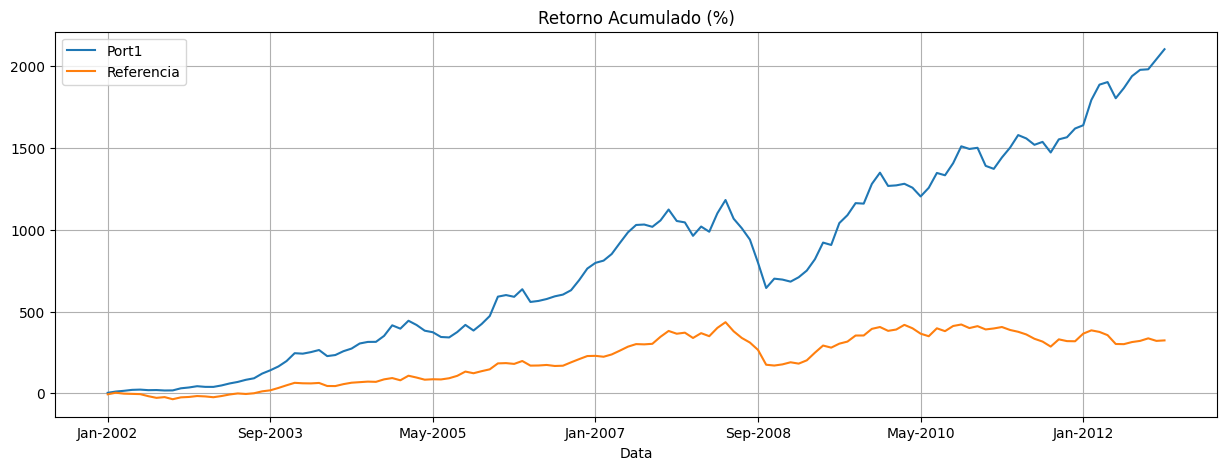

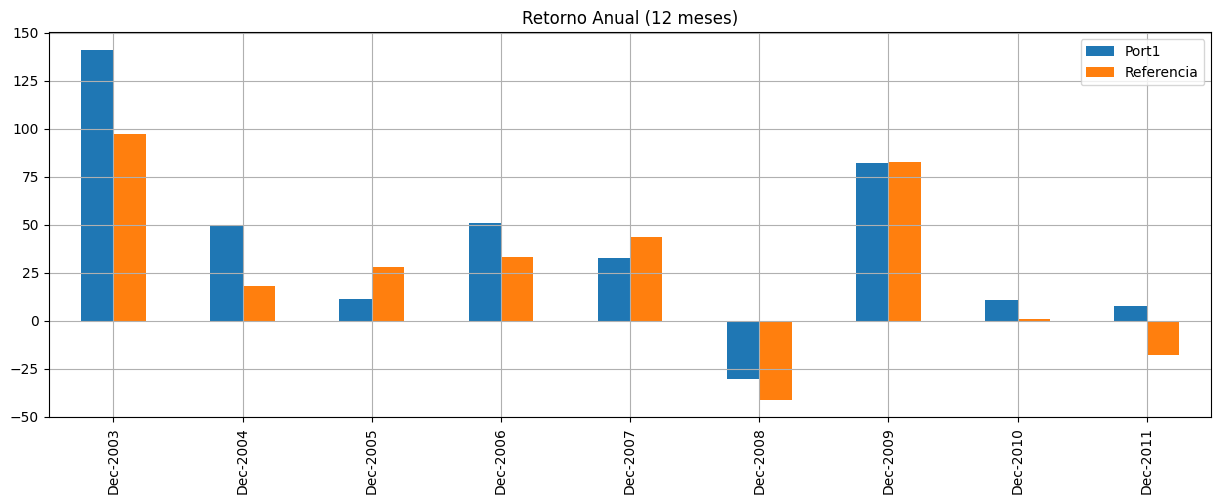

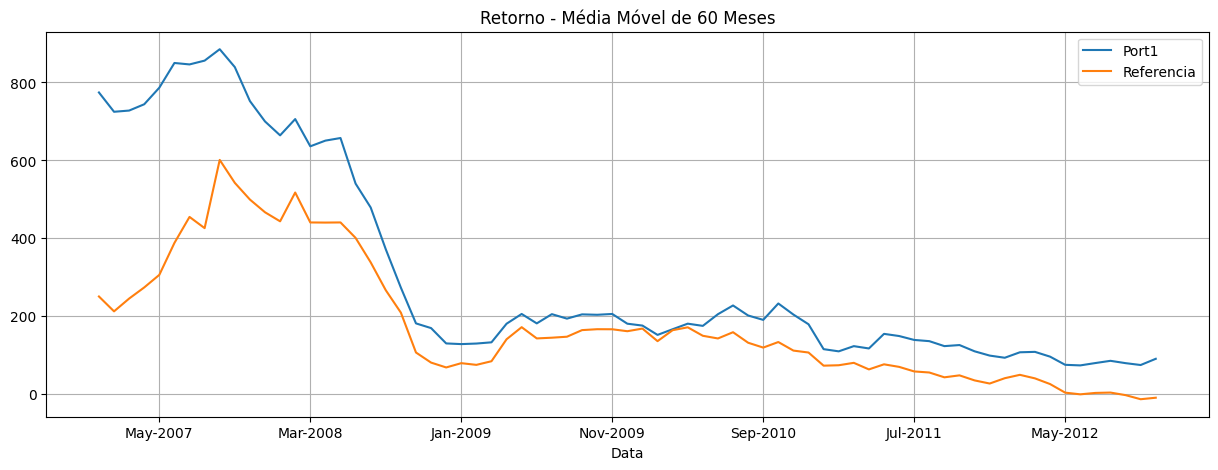

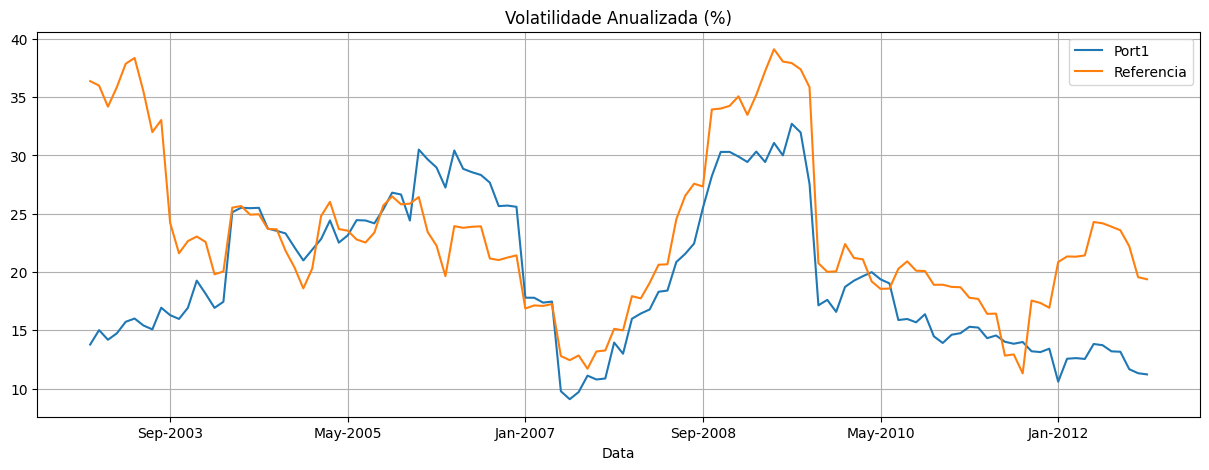

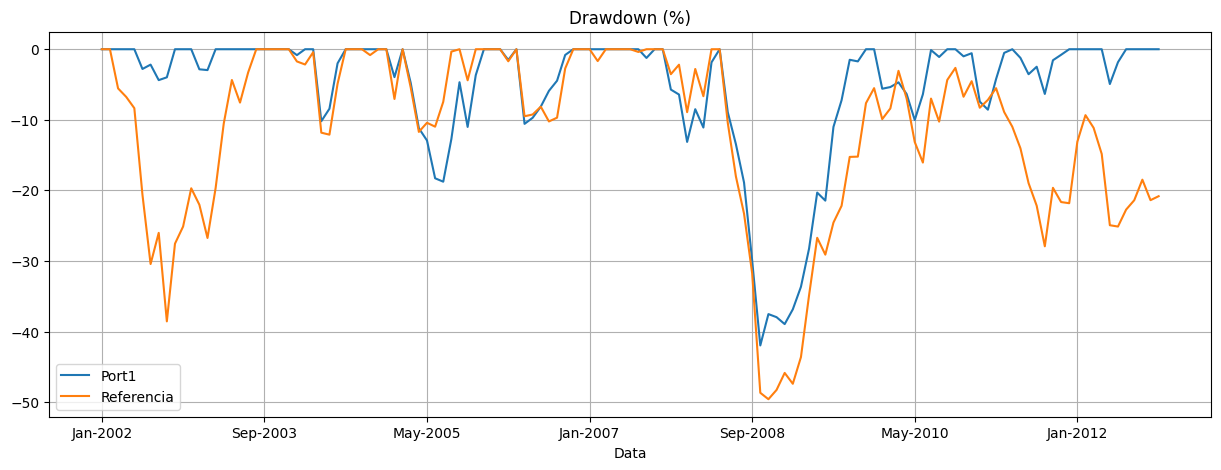

In [ ]:
# DataFrame com retornos acumulados
Port_acc = pd.DataFrame(Port1['Ret_acc'])
Port_acc.rename(columns={"Ret_acc": "Port1"}, inplace=True)

# DataFrame com retornos mensais
Port_ret_men = pd.DataFrame(Port1['Ret'])
Port_ret_men.rename(columns={"Ret": "Port1"}, inplace=True)

# Adiciona referência (IBOV)
Port_ret_men['Referencia'] = Port1['Ref']
Port_acc['Referencia'] = Port1['Ref_acc']

#Gráfico de Retorno Acumulado
(Port_acc * 100).plot(figsize=(15, 5), grid=True, title='Retorno Acumulado (%)');

#Gráfico de Retorno Anual (12 meses)
Port_12m_temp = ((1 + Port_acc) / (1 + Port_acc.shift(12)) - 1) * 100
Port_12m = Port_12m_temp.loc[pd.date_range(start=start, end=end, freq='YE').strftime('%b-%Y')].dropna()
Port_12m.plot.bar(figsize=(15, 5), grid=True, title='Retorno Anual (12 meses)');

#Gráfico de Média Móvel de 60 meses do Retorno Acumulado
med_movel = 60
Port_med_movel = ((1 + Port_acc) / (1 + Port_acc.shift(med_movel)) - 1) * 100
Port_med_movel.iloc[24:].plot(figsize=(15, 5), grid=True, title='Retorno - Média Móvel de 60 Meses');

#Gráfico de Volatilidade Anualizada (rolling 12 meses)
Port_vol_anual = (1 + Port_ret_men).rolling(12).std() * (12 ** 0.5) * 100
Port_vol_anual.plot(figsize=(15, 5), grid=True, title='Volatilidade Anualizada (%)');

#Gráfico de Drawdown
drawdown_df = pd.DataFrame(Port1['drawdown'] * 100)
drawdown_df.rename(columns={'drawdown': 'Port1'}, inplace=True)
drawdown_df['Referencia'] = ((1 + Port1['Ref_acc']) / (1 + Port1['Ref_acc'].cummax()) - 1) * 100

drawdown_df.plot(figsize=(15, 5), grid=True, title='Drawdown (%)');

In [ ]:
#Criação dos 3 melhores portfólios de retorno:
Port_roic_mom6 = create_port_2_fatores_par('ROIC', False, 'Mom6', False, 20, dados=dados, referencia=indices['IBOV'])
Port_roe_mom6 = create_port_2_fatores_par('ROE', False, 'Mom6', False, 20, dados=dados, referencia=indices['IBOV'])
Port_mom6_volat = create_port_2_fatores_par('Mom6', False, 'Volat', True, 20, dados=dados, referencia=indices['IBOV'])


Portfolio [ ROIC Mom6 20 ] 
Ret Acc: 2104.24 %  Ret anual.: 32.75 %  Vol anual.: 20.69 % Drawdown: -41.97 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 20.09 % Beta: 0.65  / P-values: 0.0 0.0 

Portfolio [ ROE Mom6 20 ] 
Ret Acc: 1899.29 %  Ret anual.: 31.57 %  Vol anual.: 21.28 % Drawdown: -40.56 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 18.79 % Beta: 0.68  / P-values: 0.0 0.0 

Portfolio [ Mom6 Volat 20 ] 
Ret Acc: 1958.58 %  Ret anual.: 31.92 %  Vol anual.: 17.96 % Drawdown: -31.65 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 20.6 % Beta: 0.55  / P-values: 0.0 0.0 



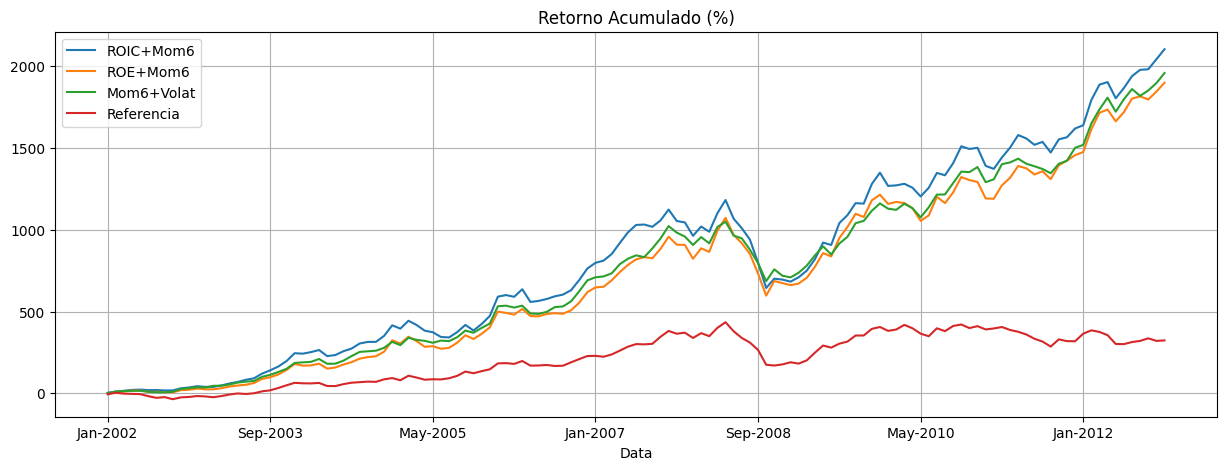

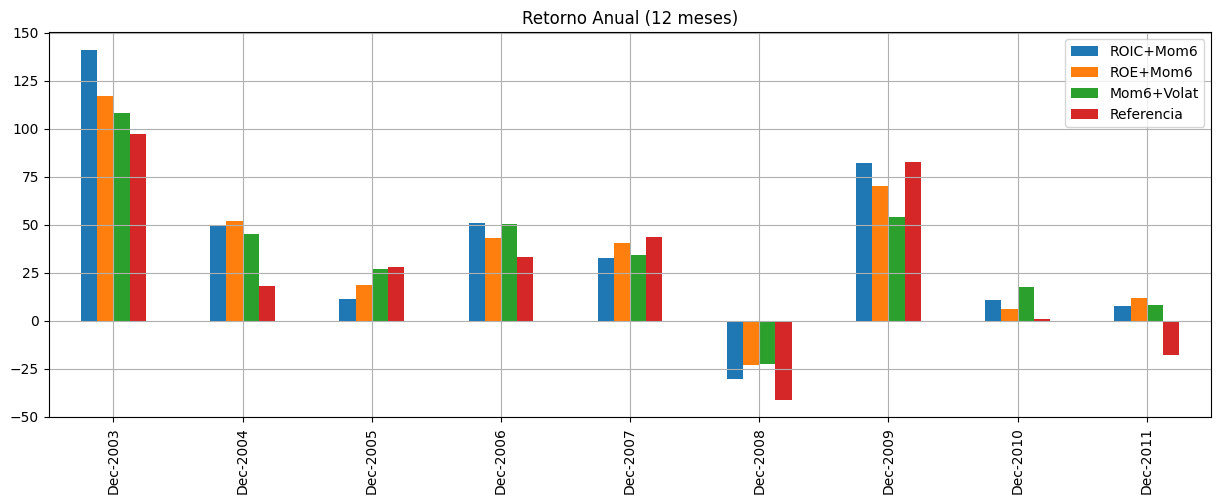

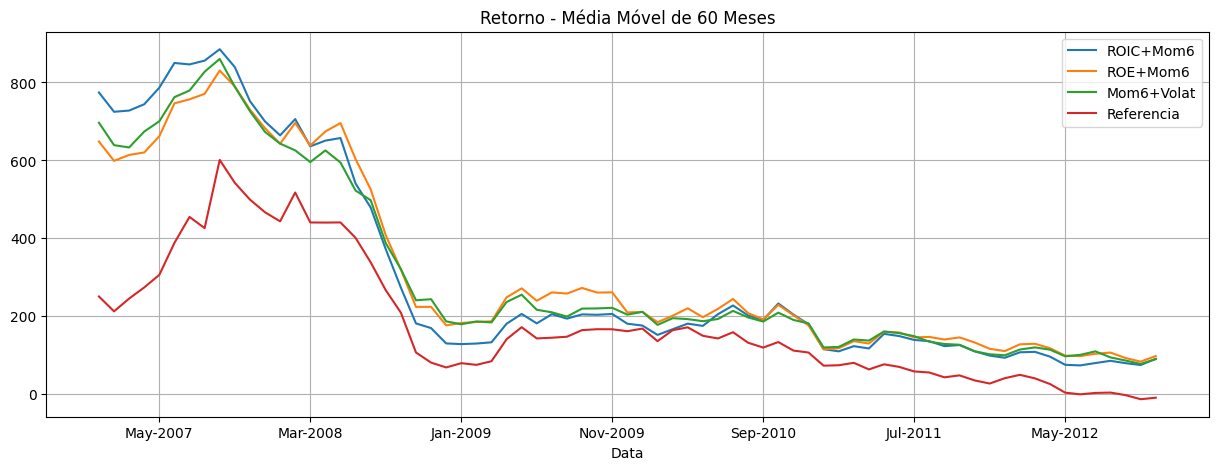

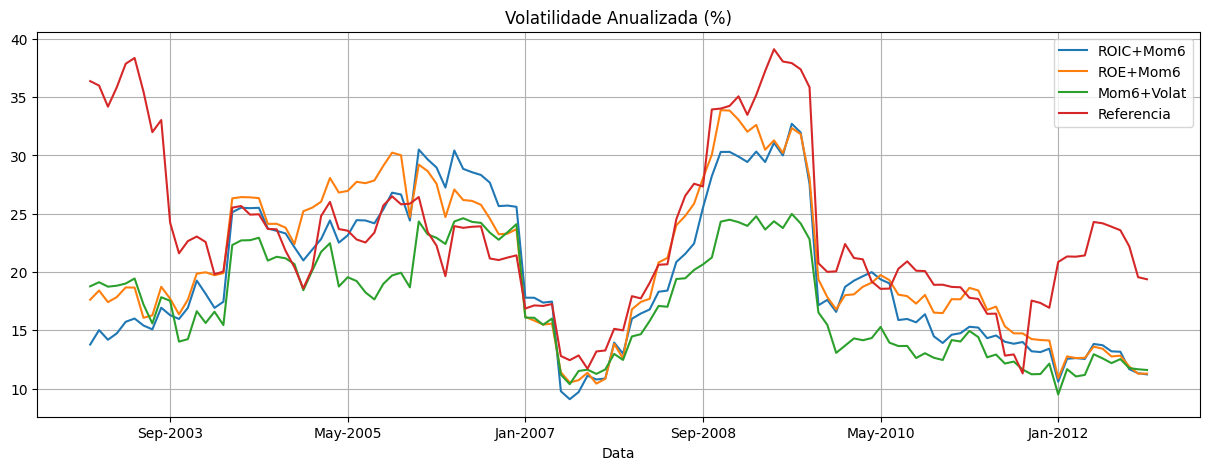

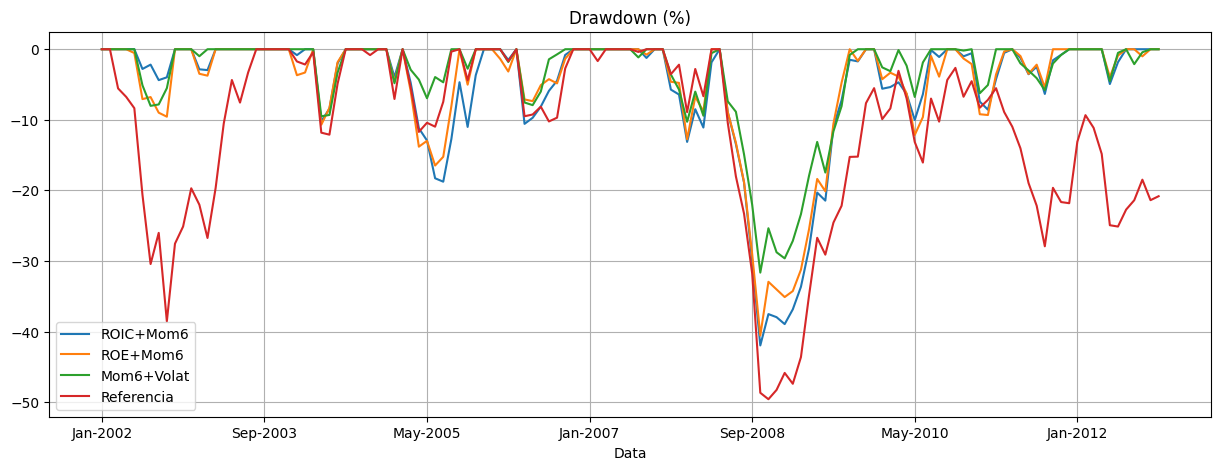

In [ ]:
#DataFrames de retorno acumulado
Port_acc = pd.DataFrame({
    'ROIC+Mom6': Port_roic_mom6['Ret_acc'],
    'ROE+Mom6': Port_roe_mom6['Ret_acc'],
    'Mom6+Volat': Port_mom6_volat['Ret_acc'],
    'Referencia': Port_roic_mom6['Ref_acc']  # mesma ref para todos
})

#DataFrames de retorno mensal
Port_ret_men = pd.DataFrame({
    'ROIC+Mom6': Port_roic_mom6['Ret'],
    'ROE+Mom6': Port_roe_mom6['Ret'],
    'Mom6+Volat': Port_mom6_volat['Ret'],
    'Referencia': Port_roic_mom6['Ref']
})

#Gráfico de Retorno Acumulado
(Port_acc * 100).plot(figsize=(15, 5), grid=True, title='Retorno Acumulado (%)');

#Retorno Anual (12 meses)
Port_12m = ((1 + Port_acc) / (1 + Port_acc.shift(12)) - 1) * 100
Port_12m = Port_12m.loc[pd.date_range(start=start, end=end, freq='YE').strftime('%b-%Y')].dropna()
Port_12m.plot.bar(figsize=(15, 5), grid=True, title='Retorno Anual (12 meses)');

#Média móvel (60 meses)
med_movel = 60
Port_med_movel = ((1 + Port_acc) / (1 + Port_acc.shift(med_movel)) - 1) * 100
Port_med_movel.iloc[24:].plot(figsize=(15, 5), grid=True, title='Retorno - Média Móvel de 60 Meses');

#Volatilidade anualizada (rolling 12 meses)
Port_vol_anual = (1 + Port_ret_men).rolling(12).std() * (12 ** 0.5) * 100
Port_vol_anual.plot(figsize=(15, 5), grid=True, title='Volatilidade Anualizada (%)');

#Drawdown
drawdown_df = pd.DataFrame({
    'ROIC+Mom6': ((1 + Port_roic_mom6['Ret_acc']) / (1 + Port_roic_mom6['Ret_acc']).cummax() - 1) * 100,
    'ROE+Mom6': ((1 + Port_roe_mom6['Ret_acc']) / (1 + Port_roe_mom6['Ret_acc']).cummax() - 1) * 100,
    'Mom6+Volat': ((1 + Port_mom6_volat['Ret_acc']) / (1 + Port_mom6_volat['Ret_acc']).cummax() - 1) * 100,
    'Referencia': ((1 + Port_roic_mom6['Ref_acc']) / (1 + Port_roic_mom6['Ref_acc']).cummax() - 1) * 100
})
drawdown_df.plot(figsize=(15, 5), grid=True, title='Drawdown (%)');


A partir da análise comparativa entre as três carteiras com maior retorno acumulado, observa-se que a carteira com o maior retorno nem sempre é a mais adequada do ponto de vista de risco. Apesar do seu excelente desempenho, ela apresenta níveis elevados de volatilidade e drawdown, o que pode torná-la menos atrativa para investidores com perfil mais conservador ou que valorizem estabilidade ao longo do tempo.

Nesse contexto, os segundo e terceiro portfólios se destacam por apresentarem resultados mais consistentes, com menor volatilidade e quedas menos acentuadas, o que os tornam alternativas mais seguras e previsíveis.

Considerando esses critérios, destaca-se a carteira formada pela combinação dos fatores Momentum 6 e ROE, que apresenta um excelente equilíbrio entre retorno e risco. O fator Momentum 6, como já mencionado, capta o efeito de inércia no desempenho recente das ações, enquanto o ROE (Return on Equity) indica a eficiência da empresa em gerar lucro sobre o capital dos acionistas. A união desses dois fatores permite selecionar empresas que estão em forte tendência de valorização e que apresentam fundamentos financeiros sólidos.

Essa carteira apresentou os seguintes resultados:

Portfolio [ ROE Mom6 20 ]
Ret Acc: 1186.97%
Ret Anual.: 27.57%
Vol Anual.: 19.15%
Drawdown: -36.25%

Referência (IBOVESPA)
Ret Acc: 323.32%
Ret Anual.: 14.13%
Vol Anual.: 24.82%

Port Alpha: 14.21%
Beta: 0.71
P-values: 0.0 / 0.0

Portanto, a carteira formada pela combinação de Momentum 6 e ROE oferece um desempenho superior ao índice de referência tanto em retorno acumulado quanto em retorno anualizado, com volatilidade inferior, drawdown controlado, alfa elevado e beta abaixo de 1, características que a tornam uma escolha muito atrativa para quem busca retorno com controle de risco.

### **Maior relação retorno/volatilidade**

A fim de encontrar a carteira de ações que gere a melhor relação retorno/volatilidade, organizou-se em um ranking de acordo com a relação buscada das carteiras geradas pelas 20 melhores ações indicadas pela combinação de dois fatores.
Plotou-se também novamente a tabela de correlação de cada fator individual com as métricas para haver uma noção de quais métricas melhor se relacionam com a razão desejada.

In [ ]:
# Calcula a correlação entre cada fator (um por vez) e as métricas
print("\nCorrelação de cada fator individual com as métricas:")
print(df_corr_ind.corr().loc[df_fator_individual.columns, [
    'Retorno acumulado (%)', 'Volatilidade anual (%)',
    'Retorno/Volatilidade', 'Alpha anual (%)', 'Beta', 'Alpha/Beta'
]])

# Calcula a razão retorno / volatilidade
df_2fatores['Retorno/Volatilidade'] = df_2fatores['Retorno acumulado (%)'] / df_2fatores['Volatilidade anual (%)']

# Ordena pela melhor relação retorno/volatilidade (quanto maior, melhor)
df_2fatores = df_2fatores.sort_values(by='Retorno/Volatilidade', ascending=False)

# Exibe o ranking
print("\nRanking de combinações de dois fatores (por Retorno/Volatilidade):")
print(df_2fatores)



Correlação de cada fator individual com as métricas:
               Retorno acumulado (%)  Volatilidade anual (%)  \
Fator_ROIC                  0.127192               -0.261614   
Fator_ROE                   0.040038                0.126530   
Fator_Mom12                 0.040035                0.088052   
Fator_Mom6                  0.543759                0.162363   
Fator_Mom3                 -0.040413                0.017952   
Fator_Volat                 0.004470               -0.809131   
Fator_PVP                   0.028414                0.421997   
Fator_Pat_Liq              -0.743496                0.253851   

               Retorno/Volatilidade  Alpha anual (%)      Beta  Alpha/Beta  
Fator_ROIC                 0.184493         0.144447 -0.179236    0.155967  
Fator_ROE                 -0.008934         0.010409  0.179795   -0.077579  
Fator_Mom12                0.003625         0.151709 -0.161105    0.147958  
Fator_Mom6                 0.452728         0.407364 -0.09146

A tabela indica que os fatores com maior correlação com a razão retorno/volatilidade são Momentum 6, Volatilidade e ROIC. Esse resultado está em linha com o embasamento teórico dos fatores e com a lógica de construção de portfólios mais eficientes.

O Momentum 6 representa o retorno das ações nos últimos seis meses, capturando o comportamento inercial do mercado — ações que tiveram bom desempenho recente tendem a continuar performando bem no curto prazo. Como esse fator está diretamente ligado ao aumento do retorno esperado, ele contribui positivamente para a elevação da razão retorno/volatilidade.

A Volatilidade, por outro lado, mede o risco (ou instabilidade) dos retornos de uma ação. Ao utilizar esse fator como critério de seleção (priorizando ações menos voláteis), tende-se a construir carteiras com menor denominador na razão retorno/volatilidade, o que, por definição, aumenta essa razão.

Já o ROIC (Return on Invested Capital) mede a eficiência da empresa em gerar retorno sobre o capital investido. Empresas com alto ROIC são financeiramente mais saudáveis e eficientes, o que tende a refletir em retornos mais estáveis e crescentes, impactando positivamente tanto o retorno quanto a estabilidade da carteira.

Portanto, a forte correlação desses três fatores com a razão retorno/volatilidade é coerente com a teoria, pois todos eles contribuem, de maneiras diferentes, para aumentar o retorno e/ou reduzir o risco, elevando assim a eficiência da carteira.

A partir do ranking de desempenho, observa-se que as carteiras formadas pelas combinações dos fatores Momentum 6 e Volatilidade, Momentum 6 e ROIC, Momentum 6 e ROE, e ROIC e Volatilidade apresentam as melhores razões retorno/volatilidade.

Essa métrica (também conhecida como índice de Sharpe simplificado) indica o quanto de retorno é gerado para cada unidade de risco assumido. Assim, quanto maior essa razão, mais eficiente é a carteira em transformar risco em retorno.

Esse resultado está de acordo com a teoria dos fatores. O fator Momentum 6 capta o efeito de persistência nos preços: ações com bom desempenho recente tendem a continuar performando bem no curto prazo. Logo, quanto mais forte o momentum, maior o potencial de valorização futura — o que eleva o retorno esperado da carteira.

Já os fatores ROIC e ROE refletem a eficiência da empresa na utilização de seus recursos para gerar lucro. Empresas com altos ROIC e ROE tendem a ser mais bem geridas e lucrativas, o que contribui para a valorização das ações.

A volatilidade, por sua vez, quando utilizada como fator de seleção (priorizando ações menos voláteis), permite montar carteiras mais estáveis, com menor risco, o que melhora diretamente a razão retorno/volatilidade.

Portanto, as combinações que envolvem esses fatores se destacam por aliar bom desempenho histórico com fundamentos sólidos e controle de risco — características essenciais para uma carteira eficiente.

Tais carteiras são analisadas nos gráficos abaixo a fim de comparar qual é a melhor indicação para formar uma carteira de ações que visa o maior retorno e a menor volatilidade.

In [ ]:
# Criação das 4 carteiras com combinações de fatores
Port_roic_mom6   = create_port_2_fatores_par('ROIC', False, 'Mom6', False, 20, dados=dados, referencia=indices['IBOV'])
Port_roe_mom6    = create_port_2_fatores_par('ROE', False, 'Mom6', False, 20, dados=dados, referencia=indices['IBOV'])
Port_mom6_volat  = create_port_2_fatores_par('Mom6', False, 'Volat', True, 20, dados=dados, referencia=indices['IBOV'])
Port_roic_volat  = create_port_2_fatores_par('ROIC', False, 'Volat', True, 20, dados=dados, referencia=indices['IBOV'])


Portfolio [ ROIC Mom6 20 ] 
Ret Acc: 2104.24 %  Ret anual.: 32.75 %  Vol anual.: 20.69 % Drawdown: -41.97 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 20.09 % Beta: 0.65  / P-values: 0.0 0.0 

Portfolio [ ROE Mom6 20 ] 
Ret Acc: 1899.29 %  Ret anual.: 31.57 %  Vol anual.: 21.28 % Drawdown: -40.56 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 18.79 % Beta: 0.68  / P-values: 0.0 0.0 

Portfolio [ Mom6 Volat 20 ] 
Ret Acc: 1958.58 %  Ret anual.: 31.92 %  Vol anual.: 17.96 % Drawdown: -31.65 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 20.6 % Beta: 0.55  / P-values: 0.0 0.0 

Portfolio [ ROIC Volat 20 ] 
Ret Acc: 1247.56 %  Ret anual.: 26.9 %  Vol anual.: 15.73 % Drawdown: -28.55 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 16.91 % Beta: 0.51  / P-values: 0.0 0.0 



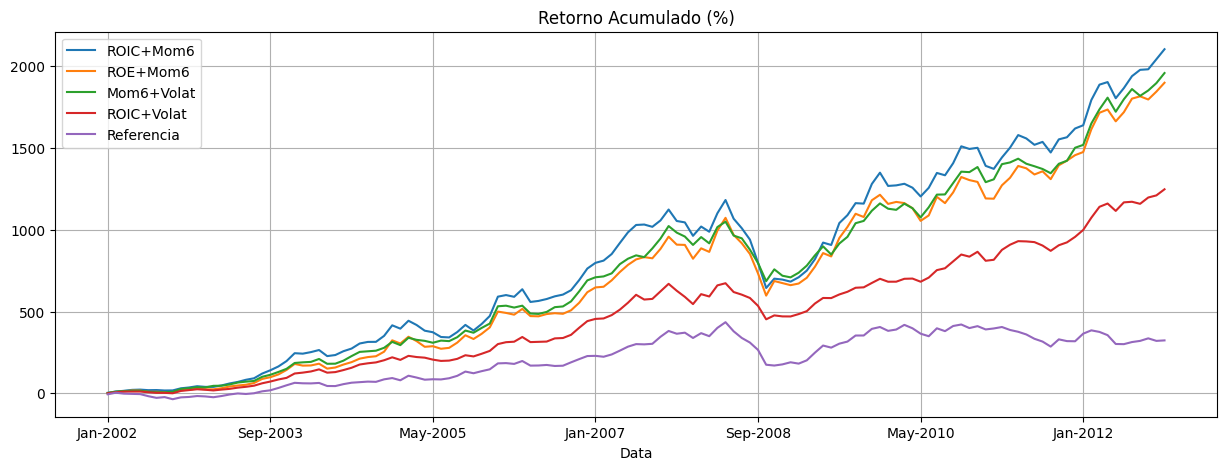

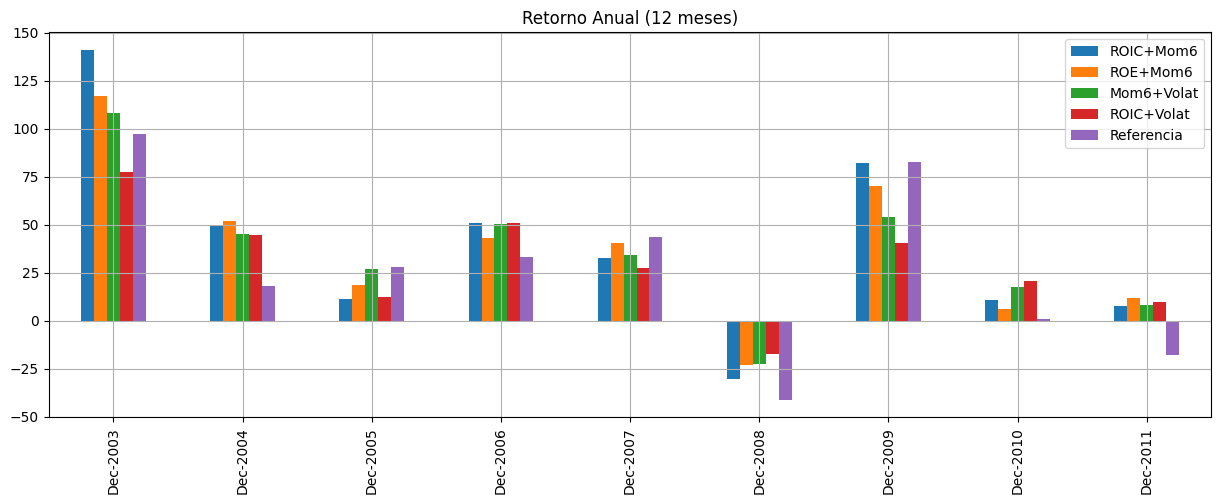

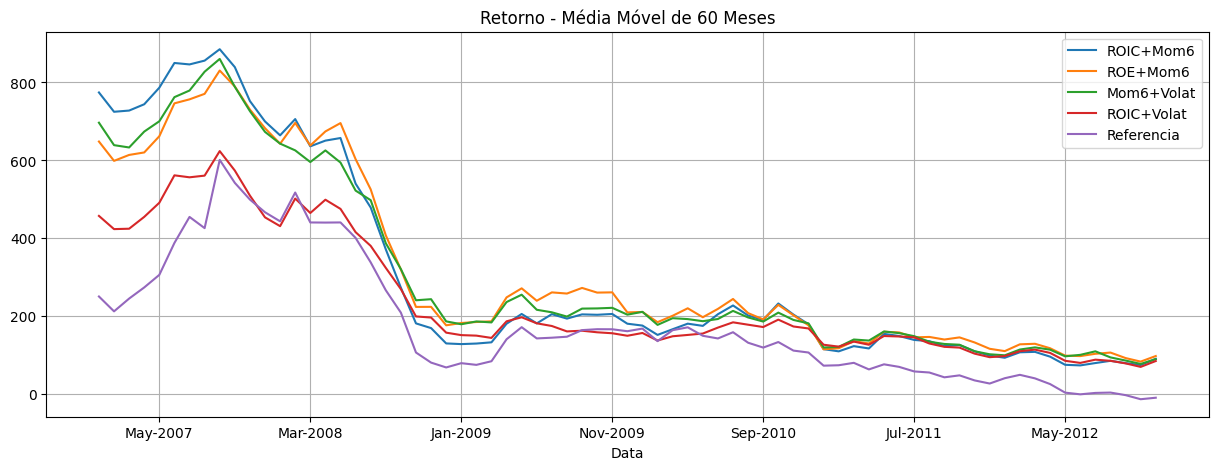

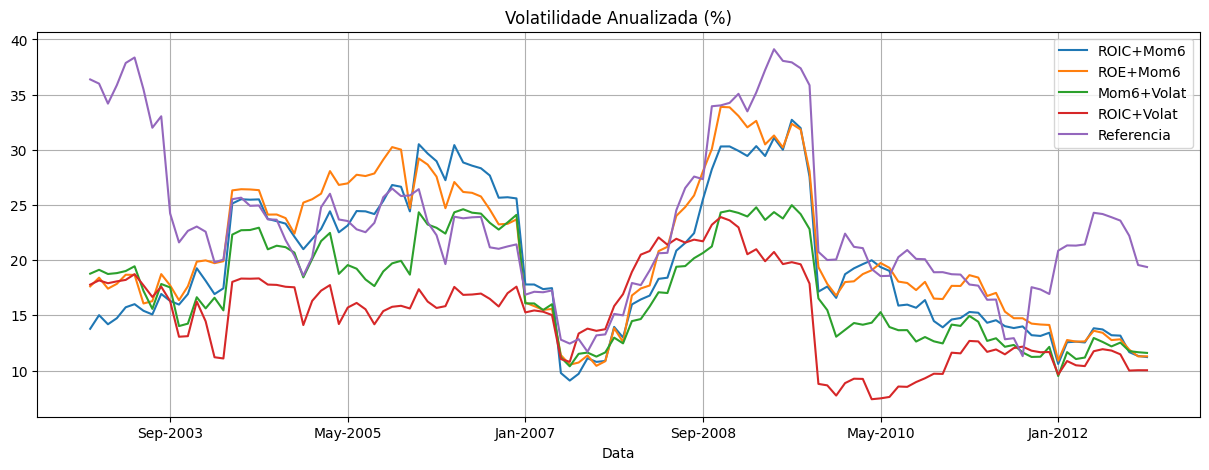

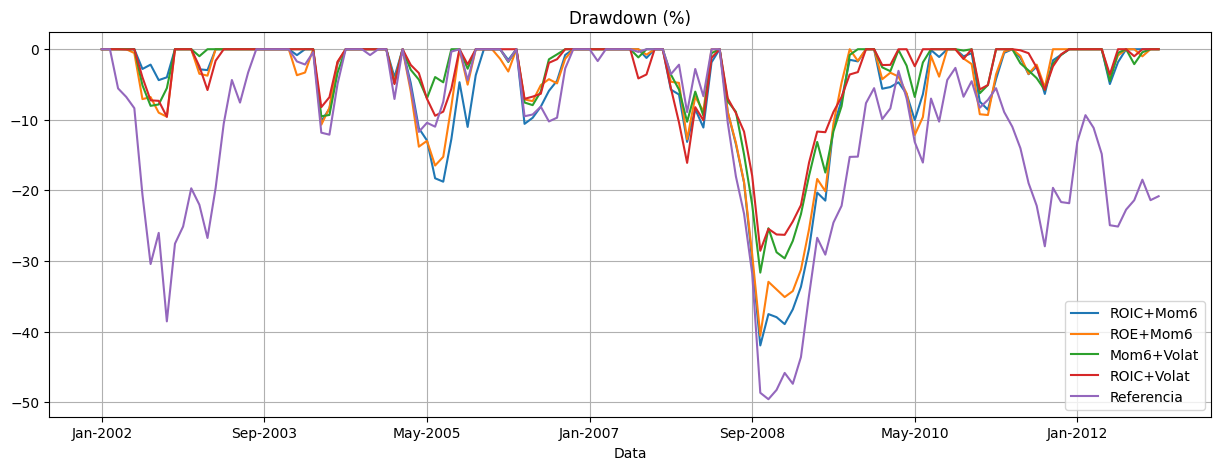

In [ ]:
# DataFrame de retorno acumulado
Port_acc = pd.DataFrame({
    'ROIC+Mom6':   Port_roic_mom6['Ret_acc'],
    'ROE+Mom6':    Port_roe_mom6['Ret_acc'],
    'Mom6+Volat':  Port_mom6_volat['Ret_acc'],
    'ROIC+Volat':  Port_roic_volat['Ret_acc'],
    'Referencia':  Port_roic_mom6['Ref_acc']  # assume mesma referência
})

# DataFrame de retorno mensal
Port_ret_men = pd.DataFrame({
    'ROIC+Mom6':   Port_roic_mom6['Ret'],
    'ROE+Mom6':    Port_roe_mom6['Ret'],
    'Mom6+Volat':  Port_mom6_volat['Ret'],
    'ROIC+Volat':  Port_roic_volat['Ret'],
    'Referencia':  Port_roic_mom6['Ref']
})

# Retorno acumulado
(Port_acc * 100).plot(figsize=(15, 5), grid=True, title='Retorno Acumulado (%)');

# Retorno anual (12 meses)
Port_12m = ((1 + Port_acc) / (1 + Port_acc.shift(12)) - 1) * 100
Port_12m = Port_12m.loc[pd.date_range(start=start, end=end, freq='YE').strftime('%b-%Y')].dropna()
Port_12m.plot.bar(figsize=(15, 5), grid=True, title='Retorno Anual (12 meses)');

# Média móvel de 60 meses
med_movel = 60
Port_med_movel = ((1 + Port_acc) / (1 + Port_acc.shift(med_movel)) - 1) * 100
Port_med_movel.iloc[24:].plot(figsize=(15, 5), grid=True, title='Retorno - Média Móvel de 60 Meses');

# Volatilidade anualizada
Port_vol_anual = (1 + Port_ret_men).rolling(12).std() * (12 ** 0.5) * 100
Port_vol_anual.plot(figsize=(15, 5), grid=True, title='Volatilidade Anualizada (%)');

# Drawdown
drawdown_df = pd.DataFrame({
    'ROIC+Mom6':   ((1 + Port_roic_mom6['Ret_acc']) / (1 + Port_roic_mom6['Ret_acc']).cummax() - 1) * 100,
    'ROE+Mom6':    ((1 + Port_roe_mom6['Ret_acc']) / (1 + Port_roe_mom6['Ret_acc']).cummax() - 1) * 100,
    'Mom6+Volat':  ((1 + Port_mom6_volat['Ret_acc']) / (1 + Port_mom6_volat['Ret_acc']).cummax() - 1) * 100,
    'ROIC+Volat':  ((1 + Port_roic_volat['Ret_acc']) / (1 + Port_roic_volat['Ret_acc']).cummax() - 1) * 100,
    'Referencia':  ((1 + Port_roic_mom6['Ref_acc']) / (1 + Port_roic_mom6['Ref_acc']).cummax() - 1) * 100
})
drawdown_df.plot(figsize=(15, 5), grid=True, title='Drawdown (%)');

As linhas verde (Mom6+Volat), azul (ROIC + Mom6) e amarela (ROE+Mom6) possuem bom retorno, todavia a menor volatilidade da linha verde indica que a carteira gerada pelas vinte melhores ações da combinação dos fatores momentum 6 e volatilidade é melhor e mais seguro para se obter uma melhor razão retorno/volatilidade.



As características desse portifólio são:

Portfolio [ Mom6 Volat 20 ]

Ret Acc: 1958.58 %  Ret anual.: 31.92 %  Vol anual.: 17.96 % Drawdown: -31.65 %

Referência
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 20.6 % Beta: 0.55  / P-values: 0.0 0.0

Ou seja, ele possui uma boa confiabilidade devido ao seu P value baixo, seu retorno acumulado, retorno anual e drawdown são melhores do que o índice de referência (IBOVESPA) e sua volatilidade é menor do que a do IBOVESPA. Além de seu alpha ser alto e beta baixo, o que indica um retorno acima do mercado com o risco controlado.

Assim, para a melhor relação entre retorno e volatilidade, a melhor escolha são as 20 melhores ações de acordo com a combinação de fatores Momentum 6 e volatilidade.

### Maior relação Alpha/Beta

A fim de encontrar a carteira de ações que gere a melhor relação alpha/beta, organizou-se em um ranking de acordo com a relação buscada das carteiras geradas pelas 20 melhores ações indicadas pela combinação de dois fatores.
Plotou-se também novamente a tabela de correlação de cada fator individual com as métricas para haver uma noção de quais métricas melhor se relacionam com a razão desejada.

In [ ]:
# Calcula a correlação entre cada fator (um por vez) e as métricas
print("\nCorrelação de cada fator individual com as métricas:")
print(df_corr_ind.corr().loc[df_fator_individual.columns, [
    'Retorno acumulado (%)', 'Volatilidade anual (%)',
    'Retorno/Volatilidade', 'Alpha anual (%)', 'Beta', 'Alpha/Beta'
]])

# Calcula a razão Alpha/Beta
df_2fatores['Alpha/Beta'] = df_2fatores['Alpha anual (%)'] / df_2fatores['Beta']

# Ordena pela melhor razão Alpha/Beta (quanto maior, melhor)
df_2fatores = df_2fatores.sort_values(by='Alpha/Beta', ascending=False)

# Exibe o ranking ordenado por Alpha/Beta
print("\nRanking de combinações de dois fatores (por Alpha/Beta):")
print(df_2fatores)



Correlação de cada fator individual com as métricas:
               Retorno acumulado (%)  Volatilidade anual (%)  \
Fator_ROIC                  0.127192               -0.261614   
Fator_ROE                   0.040038                0.126530   
Fator_Mom12                 0.040035                0.088052   
Fator_Mom6                  0.543759                0.162363   
Fator_Mom3                 -0.040413                0.017952   
Fator_Volat                 0.004470               -0.809131   
Fator_PVP                   0.028414                0.421997   
Fator_Pat_Liq              -0.743496                0.253851   

               Retorno/Volatilidade  Alpha anual (%)      Beta  Alpha/Beta  
Fator_ROIC                 0.184493         0.144447 -0.179236    0.155967  
Fator_ROE                 -0.008934         0.010409  0.179795   -0.077579  
Fator_Mom12                0.003625         0.151709 -0.161105    0.147958  
Fator_Mom6                 0.452728         0.407364 -0.09146

A tabela indica que os fatores com maior correlação com a razão alpha/beta são Volatilidade, Momentum 6, ROIC e Momentum 12. Esse resultado está alinhado com a teoria dos fatores e a construção de carteiras que buscam gerar alto desempenho ajustado ao risco de mercado.

O Momentum 6 representa o retorno das ações nos últimos seis meses, refletindo a tendência recente de valorização. Já o Momentum 12 considera o retorno dos últimos doze meses (excluindo geralmente o mais recente), oferecendo uma perspectiva mais ampla de performance sustentada. Ambos os fatores ajudam a identificar ativos com histórico positivo, contribuindo para um maior alpha — ou seja, um desempenho acima do esperado pelo risco de mercado (beta).

A Volatilidade, quando usada como critério de seleção de ações menos voláteis, reduz a sensibilidade da carteira a movimentos amplos do mercado, o que diminui o beta. Isso, por consequência, aumenta a razão alpha/beta, pois o numerador (alpha) permanece elevado enquanto o denominador (beta) é reduzido.

O ROIC (Return on Invested Capital) indica a eficiência com que uma empresa transforma capital em lucro. Empresas com alto ROIC tendem a apresentar desempenho financeiro sólido e estável, o que se traduz em retornos acima da média com menor risco de mercado — novamente contribuindo positivamente para a razão alpha/beta.

A partir do ranking das combinações de fatores, nota-se que as carteiras que mais se destacam na razão alpha/beta são aquelas formadas pelos pares:

Momentum 6 + Volatilidade

Momentum 12 + Volatilidade

ROIC + Volatilidade

Momentum 3 + Volatilidade

ROIC + Momentum 6

Isso também corrobora com o raciocínio teórico: quanto mais forte o momentum (seja de 3, 6 ou 12 meses), maior tende a ser o alpha, já que ativos com bom desempenho passado costumam continuar performando bem. Ao mesmo tempo, a presença do fator Volatilidade ajuda a manter o beta em níveis baixos, criando carteiras com alto retorno ajustado ao risco de mercado.

Tais carteiras são analisadas nos gráficos abaixo, a fim de identificar qual delas representa a melhor relação entre gerar um alto alpha (desempenho superior) e manter um baixo beta (baixa sensibilidade ao mercado), tornando-se, portanto, a melhor recomendação para quem busca desempenho acima do mercado com risco reduzido.

In [ ]:
# Criação das carteiras com diferentes combinações de fatores
Port_mom6_volat  = create_port_2_fatores_par('Mom6', False, 'Volat', True, 20, dados=dados, referencia=indices['IBOV'])
Port_mom12_volat = create_port_2_fatores_par('Mom12', False, 'Volat', True, 20, dados=dados, referencia=indices['IBOV'])
Port_mom3_volat  = create_port_2_fatores_par('Mom3', False, 'Volat', True, 20, dados=dados, referencia=indices['IBOV'])
Port_roic_volat  = create_port_2_fatores_par('ROIC', False, 'Volat', True, 20, dados=dados, referencia=indices['IBOV'])
Port_roic_mom6   = create_port_2_fatores_par('ROIC', False, 'Mom6', False, 20, dados=dados, referencia=indices['IBOV'])

Portfolio [ Mom6 Volat 20 ] 
Ret Acc: 1958.58 %  Ret anual.: 31.92 %  Vol anual.: 17.96 % Drawdown: -31.65 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 20.6 % Beta: 0.55  / P-values: 0.0 0.0 

Portfolio [ Mom12 Volat 20 ] 
Ret Acc: 1419.09 %  Ret anual.: 28.3 %  Vol anual.: 18.08 % Drawdown: -34.62 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 18.07 % Beta: 0.53  / P-values: 0.0 0.0 

Portfolio [ Mom3 Volat 20 ] 
Ret Acc: 1257.4 %  Ret anual.: 26.99 %  Vol anual.: 17.44 % Drawdown: -35.43 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 16.78 % Beta: 0.54  / P-values: 0.0 0.0 

Portfolio [ ROIC Volat 20 ] 
Ret Acc: 1247.56 %  Ret anual.: 26.9 %  Vol anual.: 15.73 % Drawdown: -28.55 %

Referência 
Ret Acc: 323.32 %  Ret anual.: 14.13 %  Vol anual.: 24.82 %

Port Alpha: 16.91 % Beta: 0.51  / P-values: 0.0 0.0 

Portfolio [ ROIC Mom6 20 ] 
Ret Acc: 2104.24 %  Ret anu

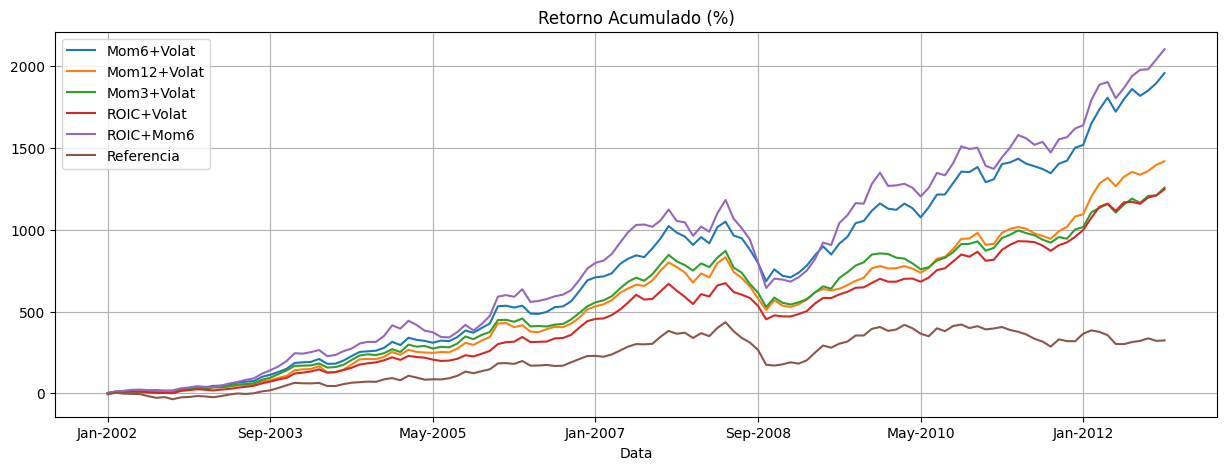

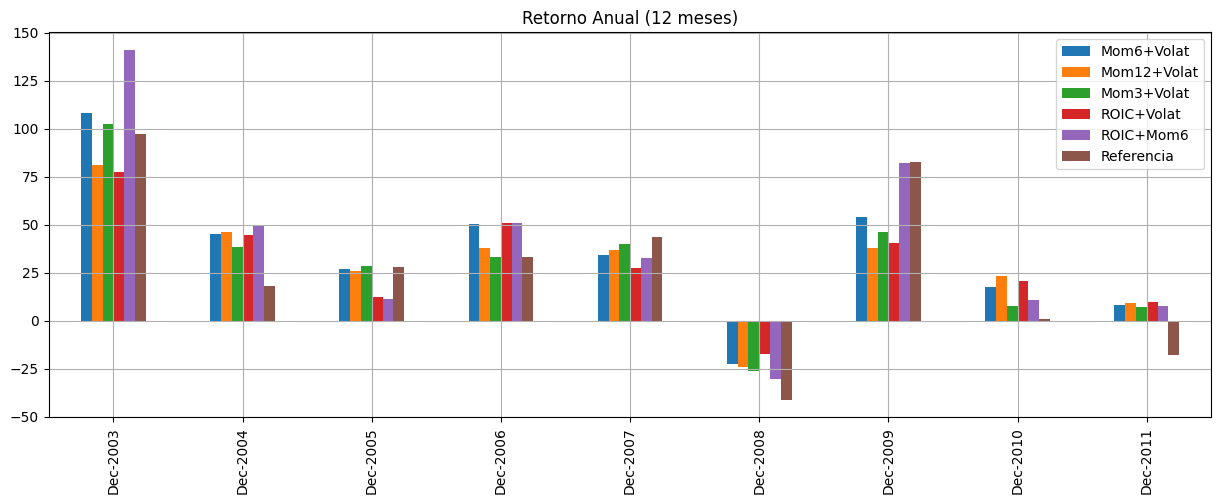

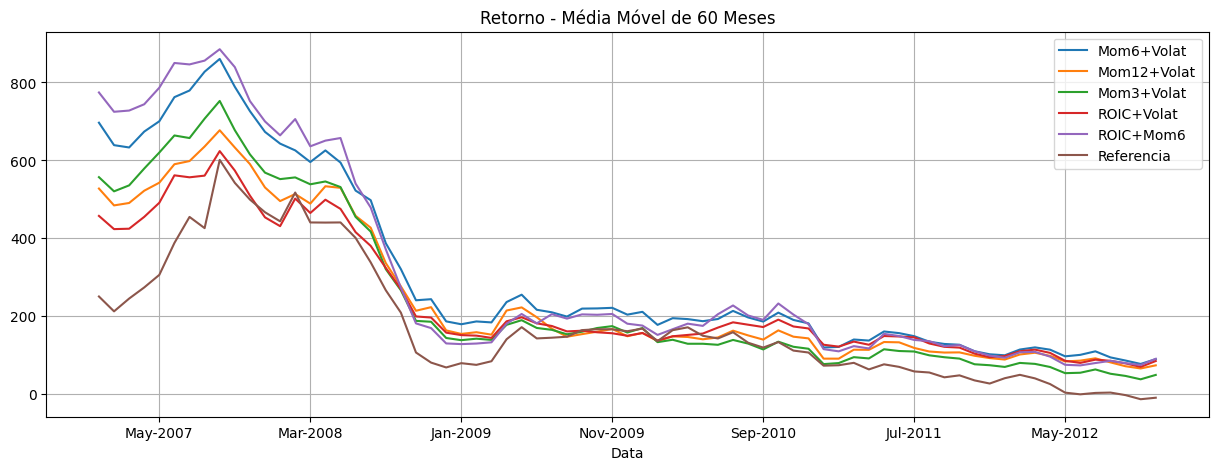

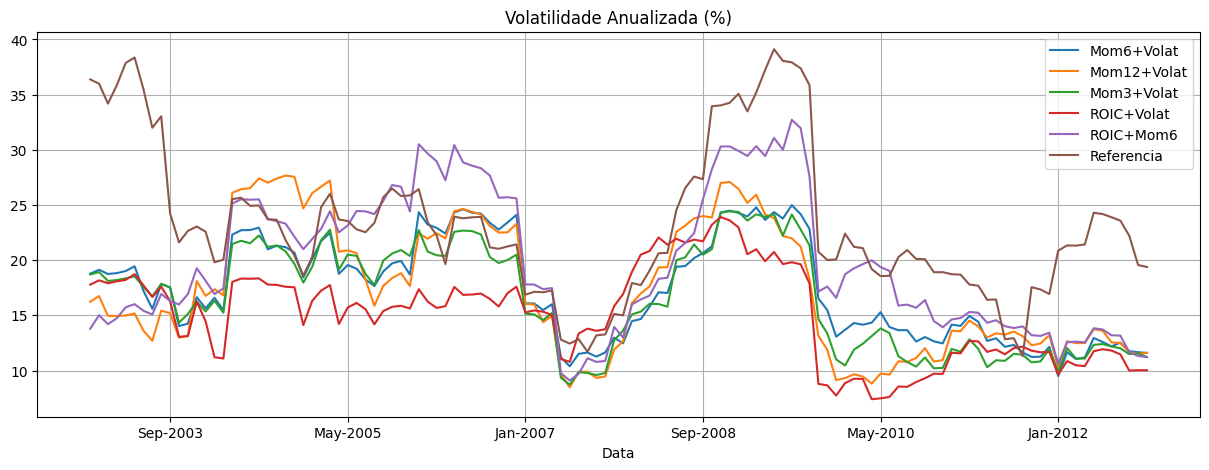

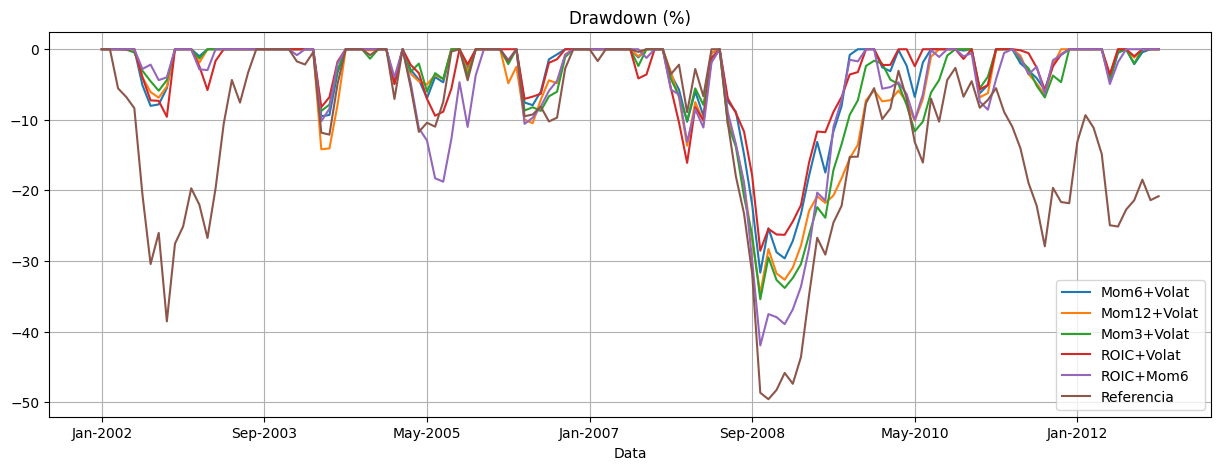

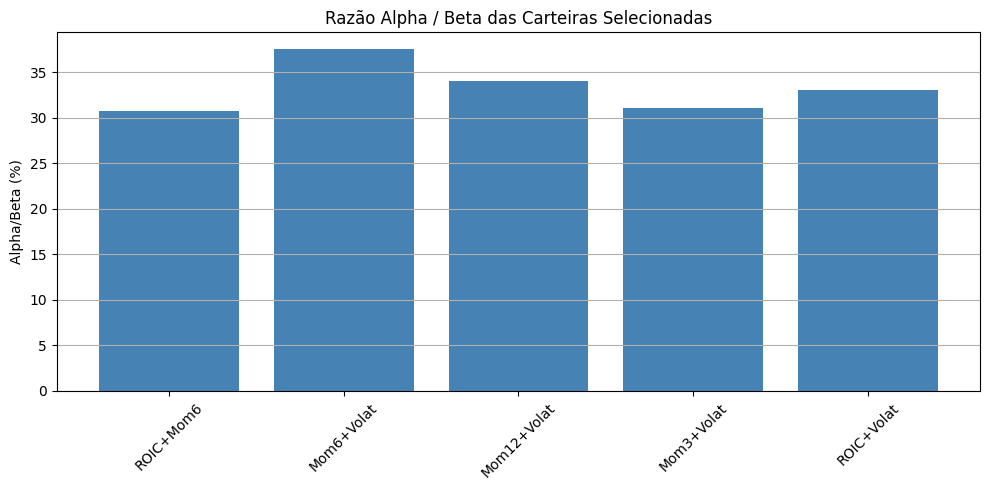

In [ ]:
# DataFrame de retorno acumulado
Port_acc = pd.DataFrame({
    'Mom6+Volat':   Port_mom6_volat['Ret_acc'],
    'Mom12+Volat':  Port_mom12_volat['Ret_acc'],
    'Mom3+Volat':   Port_mom3_volat['Ret_acc'],
    'ROIC+Volat':   Port_roic_volat['Ret_acc'],
    'ROIC+Mom6':    Port_roic_mom6['Ret_acc'],
    'Referencia':   Port_roic_mom6['Ref_acc']
})

# DataFrame de retorno mensal
Port_ret_men = pd.DataFrame({
    'Mom6+Volat':   Port_mom6_volat['Ret'],
    'Mom12+Volat':  Port_mom12_volat['Ret'],
    'Mom3+Volat':   Port_mom3_volat['Ret'],
    'ROIC+Volat':   Port_roic_volat['Ret'],
    'ROIC+Mom6':    Port_roic_mom6['Ret'],
    'Referencia':   Port_roic_mom6['Ref']
})

# Retorno acumulado
(Port_acc * 100).plot(figsize=(15, 5), grid=True, title='Retorno Acumulado (%)')

# Retorno anual (12 meses)
Port_12m = ((1 + Port_acc) / (1 + Port_acc.shift(12)) - 1) * 100
Port_12m = Port_12m.loc[pd.date_range(start=start, end=end, freq='YE').strftime('%b-%Y')].dropna()
Port_12m.plot.bar(figsize=(15, 5), grid=True, title='Retorno Anual (12 meses)')

# Média móvel de 60 meses
med_movel = 60
Port_med_movel = ((1 + Port_acc) / (1 + Port_acc.shift(med_movel)) - 1) * 100
Port_med_movel.iloc[24:].plot(figsize=(15, 5), grid=True, title='Retorno - Média Móvel de 60 Meses')

# Volatilidade anualizada
Port_vol_anual = (1 + Port_ret_men).rolling(12).std() * (12 ** 0.5) * 100
Port_vol_anual.plot(figsize=(15, 5), grid=True, title='Volatilidade Anualizada (%)')

# Drawdown
drawdown_df = pd.DataFrame({
    'Mom6+Volat':   ((1 + Port_mom6_volat['Ret_acc']) / (1 + Port_mom6_volat['Ret_acc']).cummax() - 1) * 100,
    'Mom12+Volat':  ((1 + Port_mom12_volat['Ret_acc']) / (1 + Port_mom12_volat['Ret_acc']).cummax() - 1) * 100,
    'Mom3+Volat':   ((1 + Port_mom3_volat['Ret_acc']) / (1 + Port_mom3_volat['Ret_acc']).cummax() - 1) * 100,
    'ROIC+Volat':   ((1 + Port_roic_volat['Ret_acc']) / (1 + Port_roic_volat['Ret_acc']).cummax() - 1) * 100,
    'ROIC+Mom6':    ((1 + Port_roic_mom6['Ret_acc']) / (1 + Port_roic_mom6['Ret_acc']).cummax() - 1) * 100,
    'Referencia':   ((1 + Port_roic_mom6['Ref_acc']) / (1 + Port_roic_mom6['Ref_acc']).cummax() - 1) * 100
})
drawdown_df.plot(figsize=(15, 5), grid=True, title='Drawdown (%)')

# Calcula (ou confirma) a razão Alpha/Beta
df_2fatores['Alpha/Beta'] = df_2fatores['Alpha anual (%)'] / df_2fatores['Beta']

# Para plotar a razão Alpha/Beta
# Dicionário com os nomes e portfólios desejados
portfolios = {
    'ROIC+Mom6': Port_roic_mom6,
    'Mom6+Volat': Port_mom6_volat,
    'Mom12+Volat': Port_mom12_volat,
    'Mom3+Volat': Port_mom3_volat,
    'ROIC+Volat': Port_roic_volat
}

# Loop para calcular Alpha/Beta de cada carteira
alpha_beta_dados = []

for nome, port in portfolios.items():
    modelo = sm.OLS(port['Ret'], sm.add_constant(port['Ref']), missing='drop').fit()
    alpha_anual = modelo.params.iloc[0] * 12 * 100
    beta = modelo.params.iloc[1]
    alpha_beta = alpha_anual / beta if beta != 0 else np.nan
    alpha_beta_dados.append({'Carteira': nome, 'Alpha/Beta': alpha_beta})

df_alpha_beta = pd.DataFrame(alpha_beta_dados).set_index('Carteira')

# novo gráfico
plt.figure(figsize=(10, 5))
plt.bar(df_alpha_beta.index, df_alpha_beta['Alpha/Beta'], color='steelblue')
plt.title('Razão Alpha / Beta das Carteiras Selecionadas')
plt.ylabel('Alpha/Beta (%)')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

O último gráfico apresenta a razão Alpha/Beta de cada uma das carteiras selecionadas, uma métrica que avalia o retorno ajustado ao risco sistemático. Quanto maior essa razão, melhor o desempenho da carteira em gerar retornos (alpha) por unidade de risco de mercado (beta).

Entre todas as combinações, a carteira Mom6 + Volat se destaca como a mais eficiente segundo essa métrica, indicando que ela proporciona o maior retorno ajustado ao risco entre as alternativas avaliadas.

Essa superioridade pode ser explicada pelos próprios fatores que compõem a estratégia:

  Momentum 6 meses (Mom6) identifica ativos com forte tendência de valorização recente, um sinal de persistência no comportamento dos preços, conforme respaldado pela teoria.

  Volatilidade mede o grau de oscilação dos preços. Ao incorporar esse fator, a carteira tende a favorecer ações com menor risco específico, o que contribui para uma exposição mais controlada ao mercado.

A combinação desses dois fatores permite selecionar ativos com bom histórico de desempenho e baixa variabilidade nos retornos, o que é ideal para maximizar a razão Alpha/Beta. Além disso, essa carteira também apresentou bons resultados em retorno acumulado, volatilidade e drawdown ao ser comparada com o índice de referência (IBOVESPA), o que reforça sua consistência.

Assim, com base nos dados analisados e na métrica final apresentada, conclui-se que a carteira Mom6 + Volat é a estratégia mais indicada entre as avaliadas para um portifólio que visa a razão alpha/beta, conciliando rentabilidade e controle de risco de forma eficaz.